# Bird Species Classifier for AML project using TensorFlow
## University of Vienna, SS 2022

In [57]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from tensorflow.keras import layers, Model

# To search directories
import os
import glob

# To visualize data
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')

# 1. Examine and understand data
## CSV data
The ``birds.csv`` contains information of the dataset. Let's look into the structure of the data.

In [58]:
# Create a dataframe from the csv
birds_df = pd.read_csv("../input/100-bird-species/birds.csv")
# clean column names
birds_df.columns = [col.replace(' ', '_').lower() for col in birds_df.columns]
birds_df.head()

,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [59]:
birds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62388 entries, 0 to 62387
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  62388 non-null  int64 
 1   filepaths    62388 non-null  object
 2   labels       62388 non-null  object
 3   data_set     62388 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [60]:
birds_df.value_counts("data_set").head()

data_set
train    58388
test      2000
valid     2000
dtype: int64

In [61]:
# Frequency of bird species in the whole dataset
print("|species | f|")
birds_df.value_counts("class_index")

|species | f|


class_index
224    259
144    243
287    243
363    227
396    224
      ... 
129    130
122    130
346    130
326    130
62     130
Length: 400, dtype: int64

In [62]:
# Look at csv entries for one single bird

#mask = birds_df['labels'].str.contains("ABBOTTS BABBLER") # Search for text fragment
#mask = birds_df.query('labels == "ABBOTTS BABBLER"') # query for name (case sensitive!)
mask = birds_df.loc[birds_df['class_index'] == 0]
print(mask.value_counts("data_set"))
mask

data_set
train    166
test       5
valid      5
dtype: int64


,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train
...,...,...,...,...
60388,0,valid/ABBOTTS BABBLER/1.jpg,ABBOTTS BABBLER,valid
60389,0,valid/ABBOTTS BABBLER/2.jpg,ABBOTTS BABBLER,valid
60390,0,valid/ABBOTTS BABBLER/3.jpg,ABBOTTS BABBLER,valid
60391,0,valid/ABBOTTS BABBLER/4.jpg,ABBOTTS BABBLER,valid


## Image data

In [63]:
# File directories
root_dir = "../input/100-bird-species"
train_dir = "../input/100-bird-species/train"
valid_dir = "../input/100-bird-species/valid"
test_dir = "../input/100-bird-species/test"

### Plot a bird image

../input/100-bird-species/valid/MALLARD DUCK/5.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/1.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/4.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/3.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/2.jpg
File shape:  (224, 224, 3) 



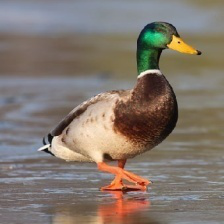

In [64]:
def showFirstBird(bird_name="MALLARD DUCK"):
    """
    Print out file paths of images in the valid_dir and show the first image of a given species.
    """
    import glob
    img_files = []
    for img in glob.glob(os.path.join(valid_dir, bird_name)+"/*"):
        img_files.append(img)
        
    for i in img_files:
        print(i) # Print file path
        ifile = tf.io.read_file(i) # Reads the contents of file
        img_dec = tf.io.decode_image(ifile) # Decodes an image file
        print("File shape: ", img_dec.shape, "\n")
        
    img = PIL.Image.open(str(img_files[0]))
    return img
    
showFirstBird()

# 2. Create a dataset for the model
## Generate tf.data.Dataset objects from a directory
Take image files from a directory on disk and generate a ``tf.data.Dataset`` for train, validation and test dataset. ``image_dataset_from_directory()`` is a special TensorFlow data generator function.

In [65]:
"""
Achieving peak performance requires an efficient input pipeline that delivers data for 
the next step before the current step has finished. The tf.data API helps to build flexible 
and efficient input pipelines.
~ https://www.tensorflow.org/guide/data_performance
"""
IMAGE_SIZE=(150,150) # original size: 224,224 # Resolution decreased to speed up training time
BATCH_SIZE=64 # default=32
SEED=42
#tf.random.set_seed(42)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE,
    seed=SEED,
    shuffle=True   # default
)
class_names = train_data.class_names
num_classes = len(class_names)
print("Class names: ", class_names[:5])

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    shuffle=True   # default
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    shuffle=False
)

Found 58388 files belonging to 400 classes.
Class names:  ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO']
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


In [66]:
train_data

<BatchDataset shapes: ((None, 150, 150, 3), (None, 400)), types: (tf.float32, tf.float32)>

## Configure the dataset for performance
To prevent I/O blocking while retrieving data from disk we use buffered prefetching.

In [67]:
"""
The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used 
to decouple the time when data is produced from the time when data is consumed. In particular, 
the transformation uses a background thread and an internal buffer to prefetch elements from 
the input dataset ahead of the time they are requested. The number of elements to prefetch 
should be equal to (or possibly greater than) the number of batches consumed by a single training step. 
You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the 
tf.data runtime to tune the value dynamically at runtime.

 ~ https://www.tensorflow.org/guide/data_performance
"""
# without cache()
train_data_pf = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
valid_data_pf = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data_pf = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# with cache()
"""
Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. If your dataset is 
too large to fit into memory, you can also use this method to create a performant on-disk cache.

 ~ https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance
"""
train_data_pfc = train_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_data_pfc = valid_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_data_pfc = test_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## Visualize the generated data
Also important to check reproducable split.

# 2.1 Standardize the data (Preprocessing)
RGB channel values range between [0, 255]. This is not ideal for a neural network; in general you should seek to make your input values small.

This can be achieved through:
- data standardization 
- image segmentation ? 
- PCA ? 

In [68]:
# This layer will standardize values to be in the range [0, 1]
normalization_layer = layers.Rescaling(1./IMAGE_SIZE[0])

# In order to use this layer we will call it at the start of our model definition.

# 3. Build the Model 

## Define layers
**Take aways from [Gabriel Atkin's Age Prediction From Facial Images](https://www.youtube.com/watch?v=9AnCNBL8c6Q&t=661s):**
- Recurrent feature extraction
- Flatten layer
    - layers.Flatten()(x) # sometimes too many features
    - layers.GlobalAveragePooling2D()(x) # average across the first 2 dimensions
- 

In [69]:
# Input layer
inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# First layer
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs) # convolution
x = layers.MaxPool2D()(x) # downsampling

# Second layer
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x) # convolution
x = layers.MaxPool2D()(x) # downsampling

# Third layer
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) # convolution
x = layers.MaxPool2D()(x) # downsampling

# Flattening layer
x = layers.GlobalAveragePooling2D()(x) 

# Dense layer
x = layers.Dense(units=128, activation='relu')(x) # twice as many units as features after flattening
x = layers.Dense(units=128, activation='relu')(x) 
x = layers.Dense(units=128, activation='relu')(x) #new test model04
x = layers.Dense(units=128, activation='relu')(x) #new test model04

# Output layer
outputs = layers.Dense(units=num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [70]:
inputs
#<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_1')>

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_3')>

In [71]:
x
# ... after the first convolution
#<KerasTensor: shape=(None, 148, 148, 16) dtype=float32 (created by layer 'conv2d_6')>
# ... after downsampling
#<KerasTensor: shape=(None, 74, 74, 16) dtype=float32 (created by layer 'max_pooling2d_6')>
##############################################################################################
# What happened up there?
# We lost 2 pixels (150->148) and we now have 16 2D features.

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_5')>

In [72]:
outputs

<KerasTensor: shape=(None, 400) dtype=float32 (created by layer 'dense_6')>

## Compile model

In [73]:
#optimizer = tf.keras.optimizers.RMSprop()
#optimizer = tf.keras.optimizers.Adam()
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)
# ~ https://blog.seeso.io/a-simple-guide-to-speed-up-your-training-in-tensorflow-2-8386e6411be4


model.compile(
    optimizer='adam',
    loss='mse',          # MSE for regression task
    metrics=['accuracy']
)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0   

### Plot the model architecture

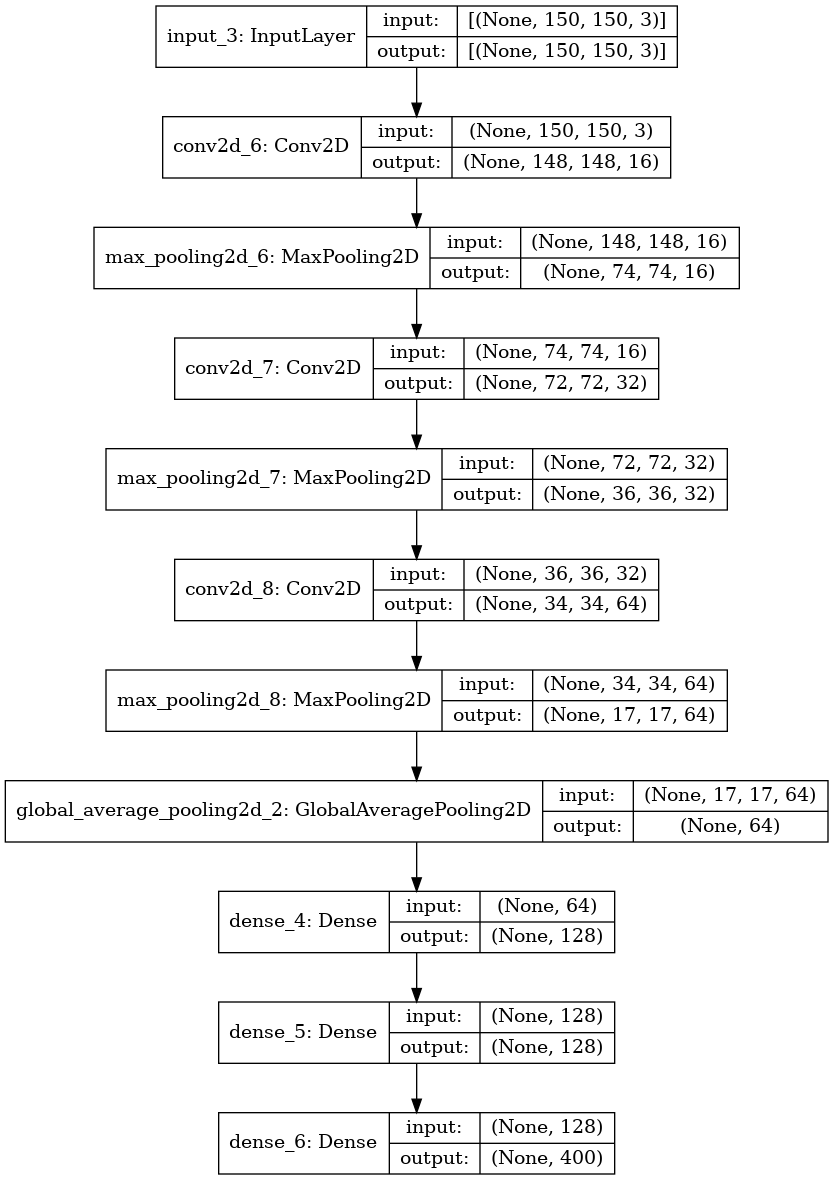

In [87]:
dot_img_file = '/tmp/'+model.name+'.png'
model_img = tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
model_img

## Train model
**Speed training time**

In [75]:
# Switch on XLA
#tf.config.optimizer.set_jit(True) # -> WARNING

In [76]:
EPOCHS = 5
STEPS = int(len(train_data_pf)*0.01)
VALIDATION_STEPS = int(len(valid_data_pf)*0.1)

print("|Epochs:", EPOCHS, "| Steps:", STEPS, "| Validation steps:", VALIDATION_STEPS, 
      "|\n**********************************************")


history = model.fit(
    train_data_pf,
    validation_data=valid_data_pf,
    validation_steps=10, # at the end of each epoch
    epochs=EPOCHS,
    workers=-1,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping( 
            #Prevent overfitting through early stopping
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1
)])

model.save("birds.h5")

|Epochs: 5 | Steps: 9 | Validation steps: 3 |
**********************************************
Epoch 1/5
913/913 [==============================] - 57s 61ms/step - loss: 0.0025 - accuracy: 0.0072 - val_loss: 0.0025 - val_accuracy: 0.0047
Epoch 2/5
913/913 [==============================] - 57s 62ms/step - loss: 0.0025 - accuracy: 0.0167 - val_loss: 0.0025 - val_accuracy: 0.0203
Epoch 3/5
913/913 [==============================] - 58s 63ms/step - loss: 0.0025 - accuracy: 0.0345 - val_loss: 0.0024 - val_accuracy: 0.0469
Epoch 4/5
913/913 [==============================] - 58s 63ms/step - loss: 0.0024 - accuracy: 0.0626 - val_loss: 0.0024 - val_accuracy: 0.1000
Epoch 5/5
913/913 [==============================] - 59s 64ms/step - loss: 0.0024 - accuracy: 0.0998 - val_loss: 0.0023 - val_accuracy: 0.1359


### Questions:
- **What is ``tf.keras.layers.Conv2D`` ?**
    - Specifies a convolution layer.
    - Let's look at an **example** ([Details](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D#args_1)): <br>
layers.Conv2D(  
...filters=16,   # dimensionality of the output space  
...kernel_size=3,   # int or tuple, height and width of the 2D convolution window  
...strides=(1,1),   # DEFAULT  
...padding='same',   # 'valid' -> no padding, 'same' -> same as input  
...groups=1,   # DEFAULT; applies filter to smaller parts of the image (~ Lupe)  
...activation='relu'   # there are many more [here](https://www.tensorflow.org/api_docs/python/tf/keras/activations)  
) 


- **What is ``tf.keras.layers.MaxPooling2D`` ?**
    - Downsamples the input along its spatial dimensions by taking the maximum value over an input window (size=``pool_size``) for each channel of the input
    - ``strides`` will shift the window
    - ``padding`` changes output size only if 'valid'  
    
    
- **What is ``tf.keras.layers.Flatten`` ?**
    - Flattens the input. Does not affect the batch size.
    
    
- **What is ``tf.keras.layers.Dropout`` ?**
    - randomly sets input units to 0 with a frequency of ``rate`` at each step during training
    - helps to prevent overfitting
    
    
- **What is ``tf.keras.layers.Dense`` ?**
    - ``units`` is a positive integer, dimensionality of the output space.
    - specify activation function to use with ``activation`` (DEFAULT='linear')
    

Source: http://bit.ly/2lXXdw5 (the Rock-Paper-Scissor model from YT)

### Model architecture from TensorFlow tutorial ([Link](https://www.tensorflow.org/tutorials/images/classification#:~:text=layers.Resizing%20layer.-,Create%20the%20model,-The%20Sequential%20model))
The Sequential model consists of three convolution blocks (``tf.keras.layers.Conv2D``) with a max pooling layer (``tf.keras.layers.MaxPooling2D``) in each of them. <br>
There's a fully-connected layer (``tf.keras.layers.Dense``) with 128 units on top of it that is activated by a ReLU activation function ('**relu**'). <br>
This model has not been tuned for high accuracy.

In [77]:
# My model adapted from web

"""INPUT_SHAPE=(150, 150, 3)

# 16, 32, 64, 128, 512 -> BUT number should decrease towards the number of classes (400)
neurons = [16, 32, 64, 128]

model = tf.keras.models.Sequential([
    # Rescaling layer to standardize data (Preprocessing)
    #layers.Rescaling(scale=1./INPUT_SHAPE[0], input_shape=INPUT_SHAPE),
    
    # The first convolution layer
    layers.Conv2D(
        input_shape=INPUT_SHAPE,
        filters=neurons[0], # 16, 32, 64
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(
        pool_size=(2,2), # DEFAULT
        strides=None, # DEFAULT
        padding='same', # DEFAULT
    ),
    
    # The second convolution layer
    layers.Conv2D(
        filters=neurons[1], # 16, 32, 64
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # The third convolution layer
    layers.Conv2D(
        filters=neurons[2], # 16, 32, 64
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # Process data for dense layers
    layers.Flatten(),
    #layers.Dropout(0.2), # higher -> more regularization 
    layers.BatchNormalization(),


    # First fully-connected layer
    layers.Dense(
        units=neurons[3], # 128
        activation='relu'
    ),
    
    # Last fully-connected layer
    layers.Dense(
        units=num_classes,
        activation='softmax',
    )
])""";

In [78]:
# Basically model from web

"""INPUT_SHAPE=(224, 224,3) 

model = tf.keras.models.Sequential([
    # Rescaling layer to standardize data (Preprocessing)
    #layers.Rescaling(scale=1./INPUT_SHAPE[0], input_shape=INPUT_SHAPE),
    
    # The first convolution layer
    layers.Conv2D(
        input_shape=INPUT_SHAPE,
        filters=16, # 16, 32, 64
        kernel_size=(3,3), 
        padding='valid', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(
        pool_size=(2,2), # DEFAULT
        strides=None, # DEFAULT
        padding='valid', # DEFAULT
    ),
    
    # The second convolution layer
    layers.Conv2D(
        filters=32, # 16, 32, 64
        kernel_size=(3,3), 
        padding='valid', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # The third convolution layer
    layers.Conv2D(
        filters=64, # 16, 32, 64
        kernel_size=(3,3), 
        padding='valid', 
        activation='relu', 
        strides=(1,1),
        groups=1
    ),
    layers.MaxPooling2D(),
    
    # Process data for dense layers
    layers.Flatten(),
    #tf.keras.layers.Dropout(0.2), # higher -> more regularization 

    # First fully-connected layer
    layers.Dense(
        units=128, 
        activation='relu'
    ),
    
    # Last fully-connected layer
    layers.Dense(
        units=num_classes,
        activation=None,
    )
])""";

**Optimizers:**
- Adam: a sensible default optimizer
- Nadam (Nesterov-accelerated Adam)
- RMSProp (oftentimes used for regression) -> keras default

In [79]:
"""model.compile(
    optimizer='adam', # DEFAULT 'rmsprop'
    loss='mean_absolute_error', 
    metrics=['accuracy']
)"""

# I used this last time
"""model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)"""

"model.compile(\n    loss=keras.losses.categorical_crossentropy,\n    optimizer='adam',\n    metrics=['accuracy']\n)"

In [80]:
#model.summary()

### Links:
- TF model.fit() -> https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- ...

# 4. Train model

In [81]:
"""EPOCHS = 5
STEPS = int(len(train_data_pf)*0.01)
VALIDATION_STEPS = int(len(valid_data_pf)*0.1)
print("|Epochs:", EPOCHS, "| Steps:", STEPS, "| Validation steps:", VALIDATION_STEPS, 
      "|\n**********************************************")

history = model.fit(   .
    train_data_pf, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS, 
    validation_data=valid_data_pf, 
    validation_steps=VALIDATION_STEPS, #3
    verbose=1
)

model.save("birds.h5")"""

'EPOCHS = 5\nSTEPS = int(len(train_data_pf)*0.01)\nVALIDATION_STEPS = int(len(valid_data_pf)*0.1)\nprint("|Epochs:", EPOCHS, "| Steps:", STEPS, "| Validation steps:", VALIDATION_STEPS, \n      "|\n**********************************************")\n\nhistory = model.fit(   .\n    train_data_pf, \n    epochs=EPOCHS, \n    steps_per_epoch=STEPS, \n    validation_data=valid_data_pf, \n    validation_steps=VALIDATION_STEPS, #3\n    verbose=1\n)\n\nmodel.save("birds.h5")'

## Training Results
### Visualize Training

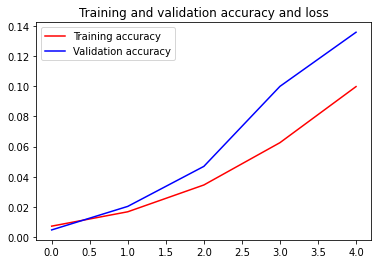

<Figure size 432x288 with 0 Axes>

In [82]:
def plotHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    #plt.plot(epochs, loss, 'g', label='Training loss')
    #plt.plot(epochs, val_loss, 'o', label='Validation loss')
    
    plt.title('Training and validation accuracy and loss')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

plotHistory(history)

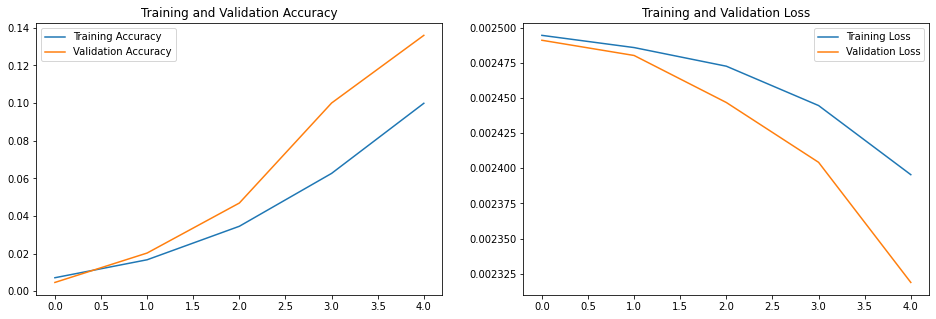

In [83]:
def plotHistory2(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()#loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()#loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
plotHistory2(history)

# 5. Evaluation

In [84]:
scores = model.evaluate(test_data_pf, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

32/32 [==============================] - 2s 62ms/step - loss: 0.0023 - accuracy: 0.1465
Accuracy: 14.65%


---
# README
after the first meeting

### Aufteilung
- keras tensorflow - Clemens
- pytorch - Jakob
- PCA + preprocessing - Lena 


### Methoden 
- pca?
- image segementation
- Wie laden wir die Bilder von der CSV ins Notebook?
- Wieviele Datenreihen brauchen wir? 
data set
| train    58388 | test      2000 | valid     2000 |


# Links
## Good Notebook for reference
### https://www.kaggle.com/code/ashwinshetgaonkar/bird-classifier-tensorflow-beginner

## Learn TensorFlow in this notebook
### http://bit.ly/2lXXdw5